# Trend Following vs Buy and Hold 

While reading [Financial Analysts Journal (Vol 73 4Q17)](https://www.cfapubs.org/toc/faj/2017/73/4) I have noticed an insightful research by Andrew Clare, James Seaton, Peter N. Smith, and Stephen Thomas in their article **[“Reducing Sequence Risk Using Trend Following and the CAPE Ratio”](https://www.cfapubs.org/doi/abs/10.2469/faj.v73.n4.5)**. Authors argue that applying a Trend Following investment strategy significantly improves chances of retirement portfolio enduring heavy losses. According to the study the strategy has many benefits and can help outperform the market by a wide margin. As all of that sounds very appealing I have decided to test that with real-life examples of backtesting 18-year performance of 3 asset classes. The time period under analysis (starting in January 1st, 2000  to December 31st, 2017)   should be compelling as it includes two full cycles with 2 crashes (dot-com bubble of 2002 and a global financial crisis of 2008).

**Trend Following strategy explanation:**
<br>First, let me clarify what is Trend Following and what assumptions I have chosen to test its efficiency. The strategy dictates when an investor should be invested in the market and when he or she should exit to earn a risk-free return instead. Switching point is indicated when month end close price of an asset is above or below a 10-month moving average. Asset price above the threshold would mean that an investor has to enter the market or hold a position. The opposite is true when a price is below the threshold than strategy dictates to exit the market when invested or stay on cash.

### Analysis assumptions:
* Starting amount of 10000 units of currency (as a strategy will be tested in USD and foreign currency as well)
* Asset divestment or holding cash when a month end close price is below 10-month moving average 
* Asset investment or holding asset when a month end close price is above 10-month moving average
* Risk-free rate of return when outside market assumed at 2% annually and is capitalized monthly on last calendar day in the month
* 18 years of data, above 4500 trading sessions with close prices 
* 3 asset classes as case studies (equity, commodity, and currencies)
* Transaction fees and commissions are ignored for simplicity reasons


### Buy and Hold vs Trend Following - finding the winning strategy:
To asses effectiveness of trend following strategy, I will compare its performance with buy and hold (also called do nothing strategy). I will analyze a few measures to make a conclusion about which one brought more favorable results. My measures of choice include:
* Final value of the initial investment (higher is better)
* Compound Annual Growth Rate (CAGR) to find the mean annual growth rate of an 18 year investment period (higher is better)
* Maximum drawdown to quantify the maximum loss from a peak to a trough of a strategy (lower is better)
* Risk-adjusted return with Sharpe ratio to indicate how much risk was involved in producing the return (higher is better)

For CAGR, Max drawdown and Sharpe ratio calculations I will use ffn module - Financial Functions for Python. It's extremely helpful library containing many useful functions for those who work in quantitative finance. More about the module and its community can be found on **[ffn GitHub repository.](https://github.com/pmorissette/ffn)**

### Importing modules and setting options:

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import ffn
sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
%matplotlib inline

## Study 1: Equity

As an equity example, I will use second-oldest U.S. market index - **The Dow Jones Industrial Average** which is composed of 30 large companies based in the United States (Apple, Coca-Cola, and Visa to name a few). In the analyzed period, the US index increased from ~11,360 points at the beginning of the year 2000 to ~24,720 points at the end of 2017. While the bull market is obvious for this timeframe, it has also endured two crashes which have reduced the capitalization by -38% in 2003 and by -49% in 2009. A performance like that should make it a good case study to verify the benefits of Trend Following strategy. 

### Quotes download

In [2]:
Start = "20000101"
End = "20180102"
equity_ticker = '^DJI'
currency_pair = 'CHFPLN'
commodity_ticker = 'XAUUSD'

In [3]:
def quotes_downloader(ticker, start, end):
    url = "".join(("https://stooq.pl/q/d/l/?s=", ticker, "&d1=", start, "&d2=", end, "&i=d"))
    df = pd.read_csv(url)
    df = df[['Data','Zamkniecie']]
    df['Data'] = pd.to_datetime(df["Data"], format='%Y-%m-%d')
    df.set_index('Data', inplace=True)
    df.rename(columns={'Zamkniecie':ticker}, inplace=True)
    return df

### Performance visualization

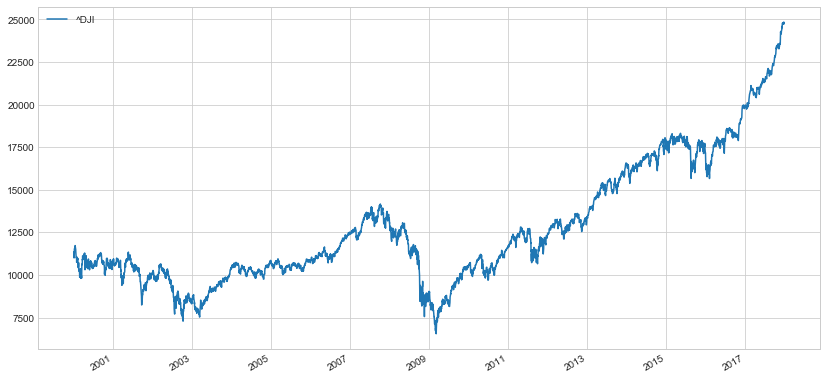

In [4]:
equity_df = quotes_downloader(equity_ticker, Start, End)
equity_df.plot(figsize=(14, 7))
plt.xlabel('');

### DataFrame with 10-month moving average based on daily returns

In [5]:
def create_daily_ma(df, ticker):
    df2 = df.copy()
    df2['Moving_Average'] = df2[ticker].rolling(window=208, min_periods=1).mean()
    df2['MA-Current_price'] = df2['Moving_Average'] - df2[ticker]
    return df2

In [6]:
equity_daily = create_daily_ma(equity_df, equity_ticker)
equity_daily.head()

,^DJI,Moving_Average,MA-Current_price
Data,,,
2000-01-03,11357.50,11357.50,0.00
2000-01-04,10997.90,11177.70,179.80
2000-01-05,11122.70,11159.37,36.67
2000-01-06,11253.30,11182.85,-70.45
2000-01-07,11522.60,11250.80,-271.80


### DataFrame with switch points and total value of investments

In [7]:
amount_to_invest = 10000
monthly_interest = 0.02 / 12
def complete_df_creator(df, ticker, Y, M, D):
    df3 = df.asfreq(freq='M', method='ffill').loc[dt.datetime(Y,M,D):]
    investment_start_price = df3[ticker][0]
    shares_bought = amount_to_invest / investment_start_price
    df3['BH_#shares'] = shares_bought
    df3['BH_final_value'] = shares_bought * df3[ticker]
    df3['action'] = 'Buy'
    df3.loc[df3['MA-Current_price'] > 0, 'action'] = 'Sell'
    df3.loc[(df3['action'] == 'Buy') & (df3['action'].shift(1) == 'Buy'),'action'] = 'Hold Asset'
    df3.loc[(df3['action'] == 'Sell') & (df3['action'].shift(1) == 'Sell'),'action'] = 'Hold Cash'
    # Set up Trend Following columns as a placeholders:
    df3['TF_#shares'] = 0
    df3['TF_equity_val'] = 0
    df3['TF_cash_val'] = 0

    n = 0
    for i, row in df3.iterrows():
        prev_val = df3['TF_equity_val'].iloc[n-1]
        prev_cash = df3['TF_cash_val'].iloc[n-1]
        prev_shares = df3['TF_#shares'].iloc[n-1]
        cur_val = row['TF_equity_val']
        cur_price = df3.loc[i,ticker]
        if row['action'] == 'Sell' and prev_shares == 0:
            df3.loc[i,'TF_#shares'] = 0
            df3.loc[i,'TF_cash_val'] = amount_to_invest
            df3.loc[i,'TF_equity_val'] = 0
        elif row['action'] == 'Sell':
            df3.loc[i,'TF_#shares'] = 0
            df3.loc[i,'TF_cash_val'] = prev_shares * cur_price
            df3.loc[i,'TF_equity_val'] = 0
        elif row['action'] == 'Hold Cash' and prev_cash == 0:
            df3.loc[i,'TF_#shares'] = 0
            df3.loc[i,'TF_cash_val'] = amount_to_invest
            df3.loc[i,'TF_equity_val'] = 0
        elif row['action'] == 'Hold Cash':
            df3.loc[i,'TF_#shares'] = 0
            df3.loc[i,'TF_cash_val'] = prev_cash * (1 + monthly_interest)
            df3.loc[i,'TF_equity_val'] = 0
        elif row['action'] == 'Buy' and prev_cash == 0:
            df3.loc[i,'TF_#shares'] = amount_to_invest / investment_start_price
            df3.loc[i,'TF_cash_val'] = 0
            df3.loc[i,'TF_equity_val'] = shares_bought * cur_price
        elif row['action'] == 'Buy':
            cur_shares = (prev_cash * (1 + monthly_interest)) / cur_price
            df3.loc[i,'TF_#shares'] = cur_shares
            df3.loc[i,'TF_cash_val'] = 0
            df3.loc[i,'TF_equity_val'] = cur_shares * cur_price
        elif row['action'] == 'Hold Asset' and prev_shares == 0:
            df3.loc[i,'TF_#shares'] = amount_to_invest / investment_start_price
            df3.loc[i,'TF_cash_val'] = 0
            df3.loc[i,'TF_equity_val'] = shares_bought * cur_price
        elif row['action'] == 'Hold Asset':
            df3.loc[i,'TF_#shares'] = prev_shares
            df3.loc[i,'TF_cash_val'] = 0
            df3.loc[i,'TF_equity_val'] = prev_shares * cur_price
        df3['TF_final_value'] = df3['TF_cash_val'] + df3['TF_equity_val']
        n += 1
    return df3

In [8]:
final_equity = complete_df_creator(equity_daily, equity_ticker, 2000, 1, 1)
final_equity.head(n=20)

,^DJI,Moving_Average,MA-Current_price,BH_#shares,BH_final_value,action,TF_#shares,TF_equity_val,TF_cash_val,TF_final_value
Data,,,,,,,,,,
2000-01-31,10940.50,11281.27,340.77,0.91,10000.00,Sell,0.00,0.00,10000.00,10000.00
2000-02-29,10128.30,10911.60,783.30,0.91,9257.62,Hold Cash,0.00,0.00,10016.67,10016.67
2000-03-31,10921.90,10755.26,-166.64,0.91,9983.00,Buy,0.92,10033.36,0.00,10033.36
2000-04-30,10733.90,10799.06,65.16,0.91,9811.16,Sell,0.00,0.00,9860.66,9860.66
2000-05-31,10522.30,10752.78,230.48,0.91,9617.75,Hold Cash,0.00,0.00,9877.09,9877.09
2000-06-30,10447.90,10723.13,275.23,0.91,9549.75,Hold Cash,0.00,0.00,9893.55,9893.55
2000-07-31,10522.00,10714.89,192.89,0.91,9617.48,Hold Cash,0.00,0.00,9910.04,9910.04
2000-08-31,11215.10,10755.67,-459.43,0.91,10250.99,Buy,0.89,9926.56,0.00,9926.56
2000-09-30,10650.90,10778.12,127.22,0.91,9735.30,Sell,0.00,0.00,9427.18,9427.18


### Asset price plot with action points and summary statistics information

In [9]:
def plot_with_actions(df, ticker):
    df3 = df.copy()
    month_ends = df3.shape[0]
    sell_df = df3[df3['action'] == 'Sell']
    sell_prices = list(sell_df[ticker])
    sell_dates = list(sell_df.index)

    buy_df = df3[df3['action'] == 'Buy']
    buy_prices = list(buy_df[ticker])
    buy_dates = list(buy_df.index)
    
    # add most recent date to buy or sell dates list to vertically color last buy / sell action
    if len(sell_dates) % 2 == 0:
        buy_dates.append(df3.index[-1])
    else:
        sell_dates.append(df3.index[-1])
    
    # To confirm if first recommended action was buy or sell
    gains = []
    losses = []
    # When sell recommendation was firts
    if sell_dates[0] < buy_dates[0]:
        for sell, buy in zip(sell_prices, buy_prices):
            if (sell - buy) > 0:
                gains.append(['S', sell, 'B', buy])
            else:
                losses.append(['S', sell, 'B', buy])

    # When sell recommendation was firts
    if sell_dates[0] > buy_dates[0]:
        for sell, buy in zip(sell_prices, buy_prices[1:]):
            if (sell - buy) > 0:
                gains.append(['S', sell, 'B', buy])
            else:
                losses.append(['S', sell, 'B', buy])

    avg_sell_gain = np.mean([x[1] for x in gains])
    avg_buy_gain = np.mean([x[3] for x in gains])
    avg_when_right = (avg_sell_gain / avg_buy_gain - 1) * 100

    avg_sell_loss = np.mean([x[1] for x in losses])
    avg_buy_loss = np.mean([x[3] for x in losses])
    avg_when_wrong = (avg_sell_loss / avg_buy_loss - 1) * 100
    
    buy_hold_final = df['BH_final_value'][-1]
    trend_following_final = df['TF_final_value'][-1]

    print('Analyze period included {} month ends with {} sell and repurchase actions:' 
          .format(month_ends, min(df3[df3['action']=='Sell'].shape[0], df3[df3['action']=='Buy'].shape[0])))
    print('*   of which {} or {:0.0f}% were correct and allowed to repurchase {:0.1f}% more asset'
         .format(len(gains), len(gains)/(len(gains) + len(losses))*100, avg_when_right))
    print('*   of which {} or {:0.0f}% were wrong and allowed to repurchase {:0.1f}% less asset '
         .format(len(losses), len(losses)/(len(gains) + len(losses))*100, avg_when_wrong))
    if buy_hold_final > trend_following_final:
        print('\nBuy and Hold outperformed Trend Follwing by {:0.1f}% or {:0.0f}' 
              .format((buy_hold_final/trend_following_final-1)*100, buy_hold_final - trend_following_final))
    elif buy_hold_final < trend_following_final:
        print('\nTrend-Following outperformed Buy and Hold by {:0.1f}% or {:0.0f}' 
              .format((trend_following_final/buy_hold_final-1)*100, trend_following_final - buy_hold_final))
    print('*   Final Value of Buy and Hold strategy is {}' .format(int(buy_hold_final)))
    print('*   Final Value of Trend Following strategy is {}' .format(int(trend_following_final)))

    
    fig, ax = plt.subplots(figsize=(14,7))
    plt.title(ticker)
    ax.plot(df3.index, df3[ticker], linewidth=2, color='k')
    
    
    # red dots to indicate a sell action on a plot
    for date, price in zip(sell_dates, sell_prices):
        plt.plot(date, price, color='r', marker='.', markersize=16)

    # green dots to indicate a repurchase action on a plot    
    for date, price in zip(buy_dates, buy_prices):
        plt.plot(date, price, color='g', marker='.', markersize=16)
        
    # axvspan to indicate buy and sell periods with vertical area
    buy_periods = []
    sell_periods = []
    if buy_dates[0] < sell_dates[0]:
        for buy, sell in zip(buy_dates, sell_dates):
            buy_periods.append((buy, sell))
        for sell, buy in zip(sell_dates, buy_dates[1:]):
            sell_periods.append((sell, buy))
    if buy_dates[0] > sell_dates[0]:
        for sell, buy in zip(sell_dates, buy_dates):
            sell_periods.append((sell, buy))
        for buy, sell in zip(buy_dates, sell_dates[1:]):
            buy_periods.append((buy, sell))
            
    for i in buy_periods:
        ax.axvspan(i[0], i[1], alpha=0.2, color='g')
    for i in sell_periods:
        ax.axvspan(i[0], i[1], alpha=0.2, color='r')

Analyze period included 216 month ends with 19 sell and repurchase actions:
*   of which 5 or 26% were correct and allowed to repurchase 10.9% more asset
*   of which 14 or 74% were wrong and allowed to repurchase -2.8% less asset 

Trend-Following outperformed Buy and Hold by 20.8% or 4690
*   Final Value of Buy and Hold strategy is 22594
*   Final Value of Trend Following strategy is 27284


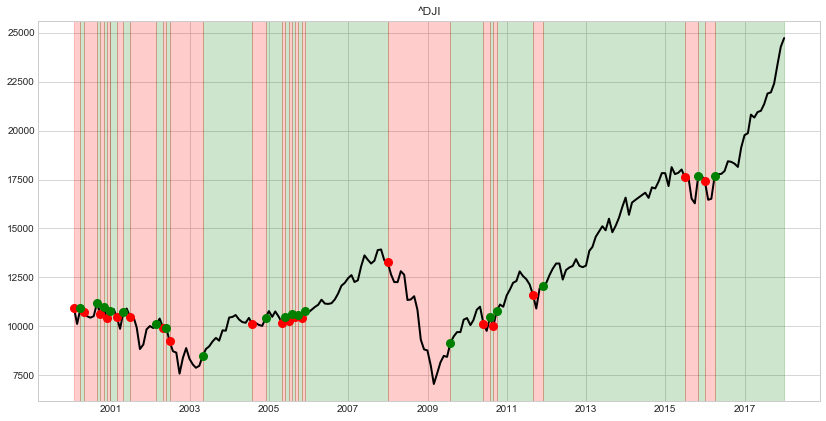

In [10]:
plot_with_actions(final_equity, equity_ticker)

### Buy & Hold vs Trend Following comparison 

In [11]:
def compirson_creator(df, ticker):
    df3 = df.copy()
    df3['TF-BH'] = df3['TF_final_value'] - df3['BH_final_value']
    df3['TF-BH_ret(%)'] = (df3['TF-BH'] / df3['BH_final_value'])*100

    fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(15,8))
    ax1.plot(df3.index, df3['BH_final_value'], linewidth = 2, color='r', alpha=0.6)
    ax1.plot(df3.index, df3['TF_final_value'], linewidth = 2, color='g', alpha=0.6)
    ax1.legend(loc='best')
    ax1.set_ylabel('Investment Value')
    ax1.set_title('Buy & Hold and Trend Following 10,000 investment performance', fontsize=15)
    ax2.fill_between(df3.index, y1=df3['TF-BH'], y2=0, color='r', alpha=0.6, where=df3['TF-BH']<0)
    ax2.fill_between(df3.index, y1=df3['TF-BH'], y2=0, color='g', alpha=0.6, where=df3['TF-BH']>0)
    ax2.set_ylabel('Difference')
    ax2.set_title('Difference (Buy & Hold - Trend Following)')
    ax2.legend(["Trend Following underperformance", "Trend Following outperformance"], loc='upper left');

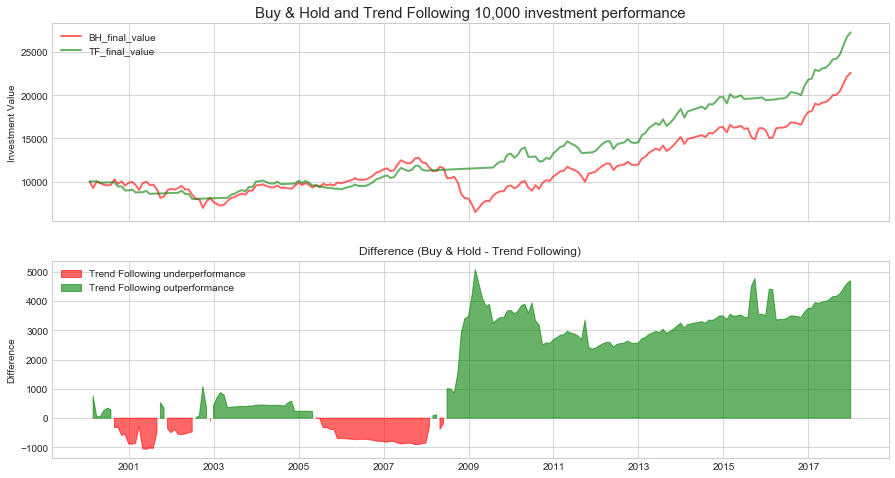

In [12]:
compirson_creator(final_equity, equity_ticker)

### CAGR, Max Drawdown, Sharpe ratio and other statistics: 

In [13]:
equity_values = final_equity[['BH_final_value', 'TF_final_value']]

In [14]:
def table_statistics(BH_price_series, TF_price_series):
    BH_end_val = round(BH_price_series[-1],0)
    TF_end_val = round(TF_price_series[-1],0)
    BH_cagr = "".join([str(round(BH_price_series.calc_cagr()*100,2)), '%'])
    TF_cagr = "".join([str(round(TF_price_series.calc_cagr()*100,2)), '%'])
    BH_drawdown = "".join([str(round(BH_price_series.calc_max_drawdown()*100,2)), '%'])
    TF_drawdown = "".join([str(round(TF_price_series.calc_max_drawdown()*100,2)), '%'])
    BH_sharpe = BH_price_series.calc_stats().stats['daily_sharpe']
    TF_sharpe = TF_price_series.calc_stats().stats['daily_sharpe']
    table_inputs = [['Final Value', BH_end_val, TF_end_val],
                  ['CAGR', BH_cagr, TF_cagr],
                  ['Max Drawdown', BH_drawdown, TF_drawdown],
                  ['Sharpe ratio', BH_sharpe , TF_sharpe]]

    table = pd.DataFrame(table_inputs, columns=['KPIs', 'Buy & Hold', 'Trend Following'])
    table = table.set_index('KPIs')
    return table

table_statistics(equity_values['BH_final_value'], equity_values['TF_final_value'])

,Buy & Hold,Trend Following
KPIs,,
Final Value,22594.00,27284.00
CAGR,4.65%,5.76%
Max Drawdown,-49.3%,-20.48%
Sharpe ratio,1.81,3.33


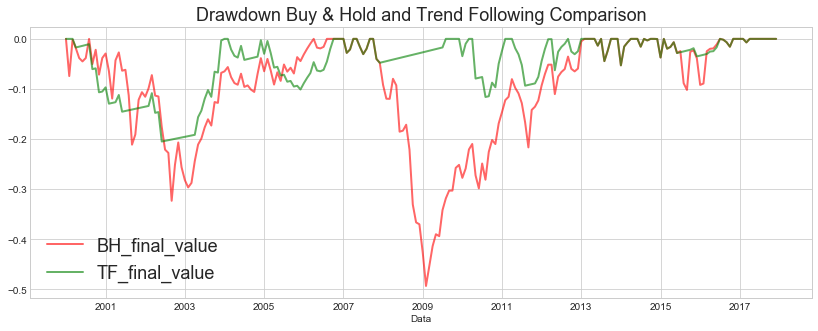

In [15]:
drawdown_graph = ffn.to_drawdown_series(equity_values).plot(figsize=(14,5), color=['r','g'], linewidth=2, alpha=0.6)
drawdown_graph.set_title('Drawdown Buy & Hold and Trend Following Comparison', fontsize=18)
drawdown_graph.legend(prop={'size': 18});

## Equity conlusion:

**Trend Following** on The Dow Jones Industrial Average **proved to be a superior strategy** on every analyzed measure. Final Value of investment delivered 17.3k profit compared to 12.6k resulted from buy and hold, which translates to **37% profit outperformance**. Even more impressive achievement **was assuming lower risk** at the same time as indicated by a significantly higher Sharpe ratio and much lower max drawdown of -20% versus staggering -49% experienced during the global financial crisis. It is worth noting here that Trend Following generated in total 19 signals for cycles of investment and divestment of which only 26% were correct while the majority was either false positive and false negative. However, when the indications were accurate it allows investors to exit the market before the full-blown crisis devastated their portfolios.

# Study 2: Commodity

As an example of commodity investment to anlyze, I have chosen **gold** reflected in USD per ounce. This yellow precious metal is famous for its protection against inflation, currency depreciation, and markets uncertainty. In analyzed period gold saw a strong momentum till 4Q 2011 when it has achieved its record high price of USD ~1900 followed by a steep decline close to USD 1050 in 4Q 2015. 

### Quotes download

In [24]:
commodity_df = quotes_downloader(commodity_ticker, Start, End)

### Performance visualization

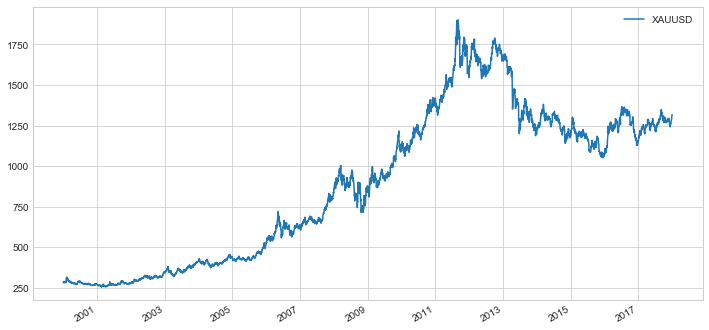

In [25]:
commodity_df.plot(figsize=(12, 6))
plt.xlabel('');

### DataFrame with 10-month moving average based on daily returns

In [26]:
commodity_daily = create_daily_ma(commodity_df, commodity_ticker)
commodity_daily.head()

,XAUUSD,Moving_Average,MA-Current_price
Data,,,
2000-01-03,289.00,289.00,0.00
2000-01-04,282.38,285.69,3.31
2000-01-05,280.85,284.08,3.23
2000-01-06,281.45,283.42,1.97
2000-01-07,281.75,283.09,1.34


### DataFrame with switch points and total value of investments

In [27]:
final_commodity = complete_df_creator(commodity_daily, commodity_ticker, 2000, 1, 1)
final_commodity.head(n=20)

,XAUUSD,Moving_Average,MA-Current_price,BH_#shares,BH_final_value,action,TF_#shares,TF_equity_val,TF_cash_val,TF_final_value
Data,,,,,,,,,,
2000-01-31,283.50,285.07,1.57,35.27,10000.00,Sell,0.00,0.00,10000.00,10000.00
2000-02-29,292.20,292.75,0.55,35.27,10306.88,Hold Cash,0.00,0.00,10016.67,10016.67
2000-03-31,278.90,290.42,11.52,35.27,9837.74,Hold Cash,0.00,0.00,10033.36,10033.36
2000-04-30,273.35,287.99,14.64,35.27,9641.98,Hold Cash,0.00,0.00,10050.08,10050.08
2000-05-31,272.10,285.23,13.13,35.27,9597.88,Hold Cash,0.00,0.00,10066.83,10066.83
2000-06-30,290.10,285.40,-4.70,35.27,10232.80,Buy,34.76,10083.61,0.00,10083.61
2000-07-31,277.25,284.87,7.62,35.27,9779.54,Sell,0.00,0.00,9636.96,9636.96
2000-08-31,277.85,283.52,5.67,35.27,9800.71,Hold Cash,0.00,0.00,9653.02,9653.02
2000-09-30,274.25,282.46,8.21,35.27,9673.72,Hold Cash,0.00,0.00,9669.11,9669.11


### Asset price plot with action points and summary statistics information

Analyze period included 216 month ends with 15 sell and repurchase actions:
*   of which 2 or 13% were correct and allowed to repurchase 16.4% more asset
*   of which 13 or 87% were wrong and allowed to repurchase -4.3% less asset 

Buy and Hold outperformed Trend Follwing by 21.7% or 8189
*   Final Value of Buy and Hold strategy is 45972
*   Final Value of Trend Following strategy is 37783


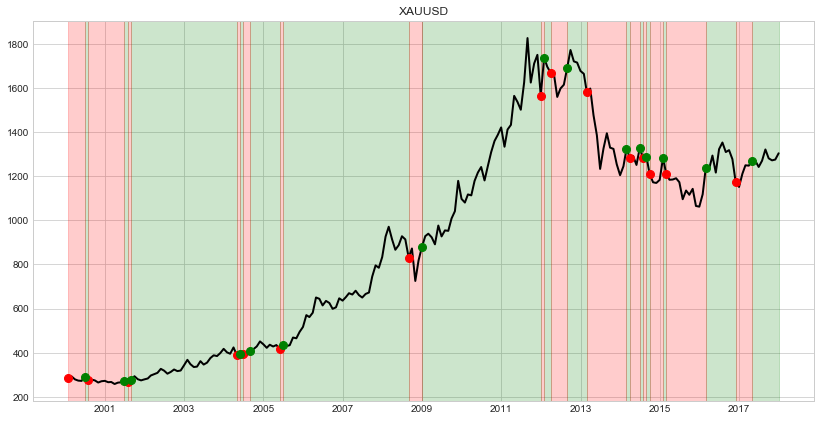

In [28]:
plot_with_actions(final_commodity, commodity_ticker)

### Buy & Hold vs Trend Following comparison 

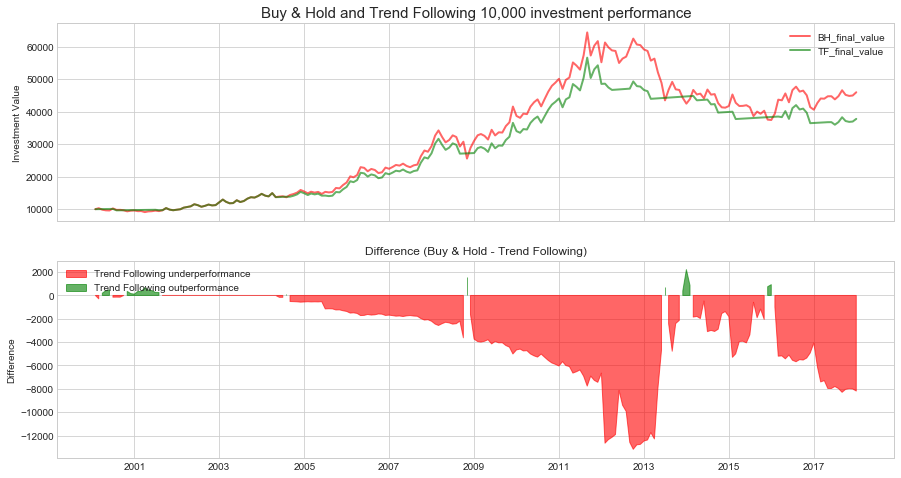

In [29]:
compirson_creator(final_commodity, commodity_ticker)

### CAGR, Max Drawdown, Sharpe ratio and other statistics:

In [30]:
commodity_value = final_commodity[['BH_final_value', 'TF_final_value']]
table_statistics(commodity_value['BH_final_value'], commodity_value['TF_final_value'])

,Buy & Hold,Trend Following
KPIs,,
Final Value,45973.00,37784.00
CAGR,8.89%,7.7%
Max Drawdown,-41.85%,-36.44%
Sharpe ratio,2.70,2.78


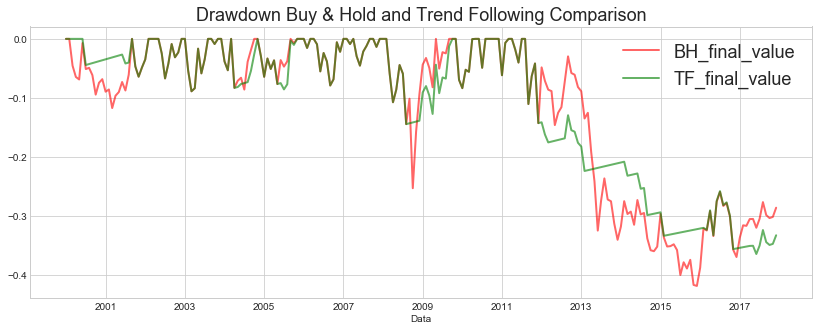

In [31]:
drawdown_graph = ffn.to_drawdown_series(commodity_value).plot(figsize=(14,5), color=['r','g'], linewidth=2, alpha=0.6)
drawdown_graph.set_title('Drawdown Buy & Hold and Trend Following Comparison', fontsize=18)
drawdown_graph.legend(prop={'size': 18});

## Commodity conlusion:

Gold trend following example proved to be a more complicated case study than Dow Jones. **Buy and hold strategy significantly outperformed T-F from both profit and return perspective** delivering USD +8.2k higher final value with 1.2% higher CAGR. However, those results were achieved by assuming moderately more risk as indicated by the slightly lower Sharpe ratio (2.7 vs 2.78) and higher max drawdown (-42% compared to -36%). I would argue that "do nothing" approach is the winning strategy as its outcome is materially better while volatility increase was not a big factor. 

# Study 3: Currency 

Last asset class I would like to check is Foreign Currency. I will use an example of **currency pair CHFPLN**.  Swiss Franc (CHF) is the currency and legal tender of Switzerland and PLN serves the same role in Poland. This pair is getting a lot of attention in Poland as in last decade a significant share of mortgages that were issued by banks in Poland were denominated in the Swiss Franc. Majority of this issuance activity was when CHF was below 2.5 PLN. Afterward Swiss Franc appreciated to levels above 3 PLN (with max exceeding 4 PLN)  which in many cases lead to an increase of loan to value ratio (LTV) for mortgages above 100%. Would Trend Following investment in CHF by Polish investor help to better hedge the risk? 

### Quotes download

In [16]:
currency_df = quotes_downloader(currency_pair, Start, End)

### Performance visualization

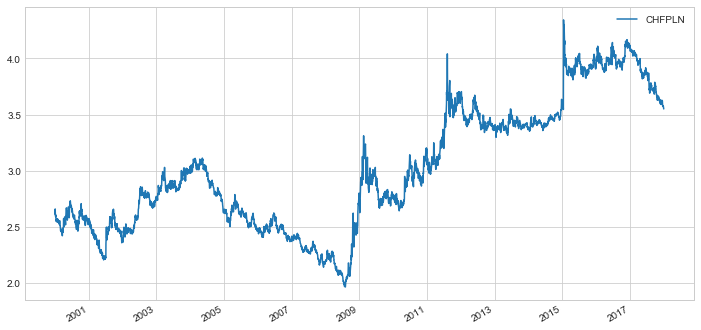

In [17]:
currency_df.plot(figsize=(12, 6))
plt.xlabel('');

### DataFrame with 10-month moving average based on daily returns

In [18]:
currency_daily = create_daily_ma(currency_df, currency_pair)
currency_daily.head()

,CHFPLN,Moving_Average,MA-Current_price
Data,,,
2000-01-03,2.61,2.61,0.00
2000-01-04,2.65,2.63,-0.02
2000-01-05,2.66,2.64,-0.02
2000-01-06,2.62,2.63,0.02
2000-01-07,2.60,2.63,0.03


### DataFrame with switch points and total value of investments

In [19]:
final_currency = complete_df_creator(currency_daily, currency_pair, 2000, 1, 1)
final_currency.head(n=20)

,CHFPLN,Moving_Average,MA-Current_price,BH_#shares,BH_final_value,action,TF_#shares,TF_equity_val,TF_cash_val,TF_final_value
Data,,,,,,,,,,
2000-01-31,2.55,2.58,0.03,3920.65,10000.00,Sell,0.00,0.00,10000.00,10000.00
2000-02-29,2.50,2.56,0.06,3920.65,9805.14,Hold Cash,0.00,0.00,10016.67,10016.67
2000-03-31,2.48,2.52,0.04,3920.65,9740.85,Hold Cash,0.00,0.00,10033.36,10033.36
2000-04-30,2.59,2.53,-0.06,3920.65,10154.08,Buy,3880.49,10050.08,0.00,10050.08
2000-05-31,2.61,2.55,-0.07,3920.65,10235.24,Hold Asset,3880.49,10130.41,0.00,10130.41
2000-06-30,2.67,2.57,-0.10,3920.65,10455.97,Hold Asset,3880.49,10348.88,0.00,10348.88
2000-07-31,2.60,2.57,-0.03,3920.65,10207.79,Hold Asset,3880.49,10103.25,0.00,10103.25
2000-08-31,2.51,2.57,0.06,3920.65,9823.96,Sell,0.00,0.00,9723.35,9723.35
2000-09-30,2.62,2.57,-0.06,3920.65,10283.46,Buy,3713.28,9739.55,0.00,9739.55


### Asset price plot with action points and summary statistics information

Analyze period included 216 month ends with 21 sell and repurchase actions:
*   of which 5 or 24% were correct and allowed to repurchase 5.9% more asset
*   of which 16 or 76% were wrong and allowed to repurchase -2.4% less asset 

Trend-Following outperformed Buy and Hold by 20.7% or 2905
*   Final Value of Buy and Hold strategy is 14005
*   Final Value of Trend Following strategy is 16911


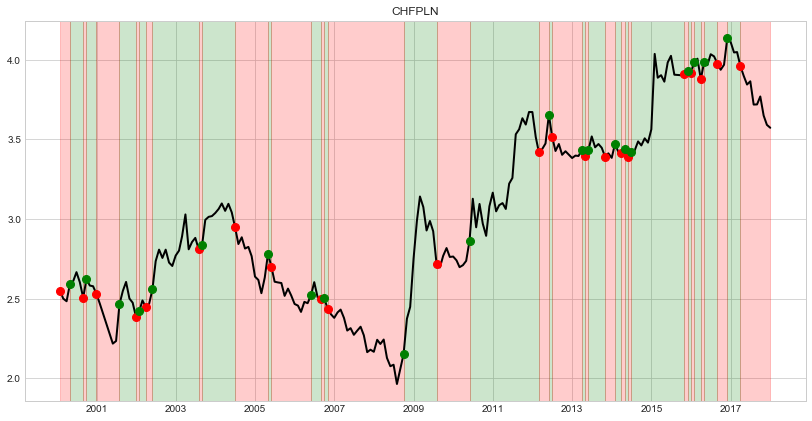

In [20]:
plot_with_actions(final_currency, currency_pair)

### Buy & Hold vs Trend Following comparison 

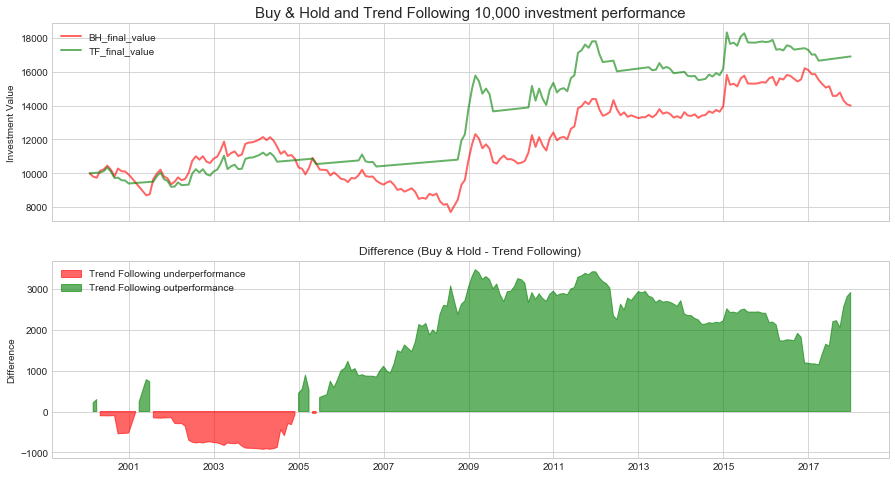

In [21]:
compirson_creator(final_currency, currency_pair)

### CAGR, Max Drawdown, Sharpe ratio and other statistics:

In [22]:
currency_value = final_currency[['BH_final_value', 'TF_final_value']]
table_statistics(currency_value['BH_final_value'], currency_value['TF_final_value'])

,Buy & Hold,Trend Following
KPIs,,
Final Value,14006.00,16911.00
CAGR,1.9%,2.98%
Max Drawdown,-36.55%,-13.41%
Sharpe ratio,1.03,1.70


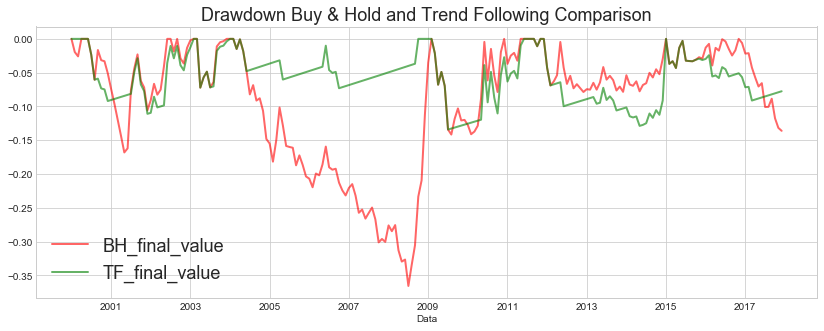

In [23]:
drawdown_graph = ffn.to_drawdown_series(currency_value).plot(figsize=(14,5), color=['r','g'], linewidth=2, alpha=0.6)
drawdown_graph.set_title('Drawdown Buy & Hold and Trend Following Comparison', fontsize=18)
drawdown_graph.legend(prop={'size': 18});

## Currency conlusion:

Investment in CHFPLN with Trend Following strategy once again delivered excellent result. It managed to **outperform Buy and Hold on every chosen measure**. The final value of FX portfolio is significantly higher (PLN 16.9k vs PLN 14k), while max drawdown is only -13.4% against unsettling -36.6%. The example above confirms that Trend Following can be an effective method also on FX markets.